In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_curve

import re

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer #word stemmer class
lemma = WordNetLemmatizer()

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization
from keras.layers.embeddings import Embedding

In [ ]:
pip install --upgrade gensim

Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)


In [ ]:
pip install sastrawi

In [ ]:

# Utilities
import re
import pickle
import numpy as np
import pandas as pd

# Plot libraries
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from gensim.models.fasttext import FastText

In [ ]:
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/NegativeDetection.csv', encoding=DATASET_ENCODING)


dataset['sentiment'] = dataset['sentiment'].replace(1,0)
dataset['sentiment'] = dataset['sentiment'].replace(-1,1)
display(dataset.head(9000))

,sentiment,tweet
0,1,pernah pake indihome dan sekarang pake first m...
1,1,akhirnya seminggu ga ada solusi ke cilacapkata...
2,1,lama lama gua jual ni router ama stb box indih...
3,1,gak perlu dijawab lagi krn td siang sdh ada yg...
4,1,kalo cuma mohon maaf doank mah enak di kalian ...
...,...,...
8995,0,aku lebih suka bayar pakai app lebih kudah sih...
8996,0,sangat membantu aplikasinya karena bisa diguna...
8997,0,benar bangetcek tagihan jadi lebih mudah
8998,0,bayar pakai app nya lebih mudah sih


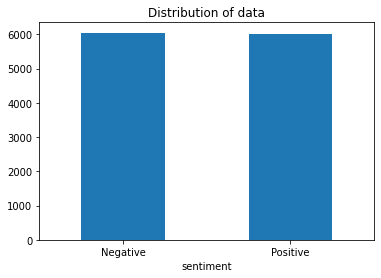

In [ ]:
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [ ]:
 # Reading contractions.csv and storing it as a dict.
# contractions = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/contractions.csv', index_col='Contraction')
# contractions.index = contractions.index.str.lower()
# contractions.Meaning = contractions.Meaning.str.lower()
# contractions_dict = contractions.to_dict()['Meaning']
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
# Defining regex patterns.
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"

def preprocess_apply(tweet):

    # import StopWordRemoverFactory class
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    tweet=stopword.remove(tweet)
    # print(tweet)

    tweet = tweet.lower()

  #stemming bahasa indonesia
    # factory = StemmerFactory()
    # stemmer = factory.create_stemmer()
    # tweet = stemmer.stem(tweet)

  
    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    # Replace #Hashtags to '<hashtags>'.
    tweet = re.sub(userPattern,'<hashtag>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    # for contraction, replacement in contractions_dict.items():
    #     tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    return tweet

In [ ]:
%%time
dataset['processed_text'] = dataset.tweet.apply(preprocess_apply)

CPU times: user 1.03 s, sys: 976 µs, total: 1.03 s
Wall time: 1.03 s


In [ ]:
count=0
for row in dataset.itertuples():
    print("Text:", row[2])
    print("Processed:", row[3])
    count+=1
    if count>10:
        break

Text: pernah pake indihome dan sekarang pake first mediamurah euy first mediasinyal juga lumayan sih kalo di tempatku
Processed: pernah pake indihome sekarang pake first mediamurah euy first mediasinyal lumayan sih kalo tempatku
Text: akhirnya seminggu ga ada solusi ke cilacapkatanya sama sekali belum ada tiket perbaikan buat wifiku dibuatlah tiket dan suruh nunggu lagi hari hari ditunggu belum dateng juga dihari ke adik ke kamtor cilacap lagi dan dibilang hari ini mau datang teknisinya
Processed: akhirnya seminggu ga solusi cilacapkatanya sama sekali ada tiket perbaikan buat wifiku dibuatlah tiket suruh nunggu hari hari ditunggu dateng dihari adik kamtor cilacap dan dibilang hari mau datang teknisinya
Text: lama lama gua jual ni router ama stb box indihomerefund blm keluar lagi ahelaaah
Processed: lama lama gua jual ni router ama stb box indihomerefund blm keluar ahelaah
Text: gak perlu dijawab lagi krn td siang sdh ada yg jawabintinya yg bikin saya kecewakenapa di awal pergantian upg

In [ ]:
!pip install fasttext

     |████████████████████████████████| 71kB 8.6MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3093625 sha256=67786c0a06db186d8d78c474f5c4d51cdc763b5724a80eb3b6a4f9cbd345e58a
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [ ]:
import fasttext

In [ ]:
ft = fasttext.load_model('/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/cc.id.300.bin')

In [ ]:
embeddings_index = dict()
for word in ft.words:
  coefs = np.asarray(ft.get_word_vector(str(word)).tolist(), dtype='float32')
  embeddings_index[word] = coefs

In [ ]:

max_length = dataset.processed_text.apply(lambda x: len(x.split())).max()

t = Tokenizer()
t.fit_on_texts(dataset.processed_text)
vocab_size = len(t.word_index) + 1
encoded_tweets = t.texts_to_sequences(dataset.processed_text)
padded_tweets = pad_sequences(encoded_tweets, maxlen=max_length, padding='post')

vocab_size = len(t.word_index) + 1

In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(padded_tweets, dataset.sentiment, test_size=0.1, stratify=dataset.sentiment,random_state=3)

In [ ]:
from tensorflow import keras
model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 300
, input_length=max_length, weights=[embedding_matrix], trainable=True))
model_glove.add(Bidirectional(LSTM(128,dropout=0.3, recurrent_dropout=0.3, return_sequences=True)))
model_glove.add(BatchNormalization())
model_glove.add(Bidirectional(LSTM(64,dropout=0.3,recurrent_dropout=0.3,return_sequences=False)))
model_glove.add(BatchNormalization())
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(64, activation='relu'))
model_glove.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.RMSprop(learning_rate=0.0001)
model_glove.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

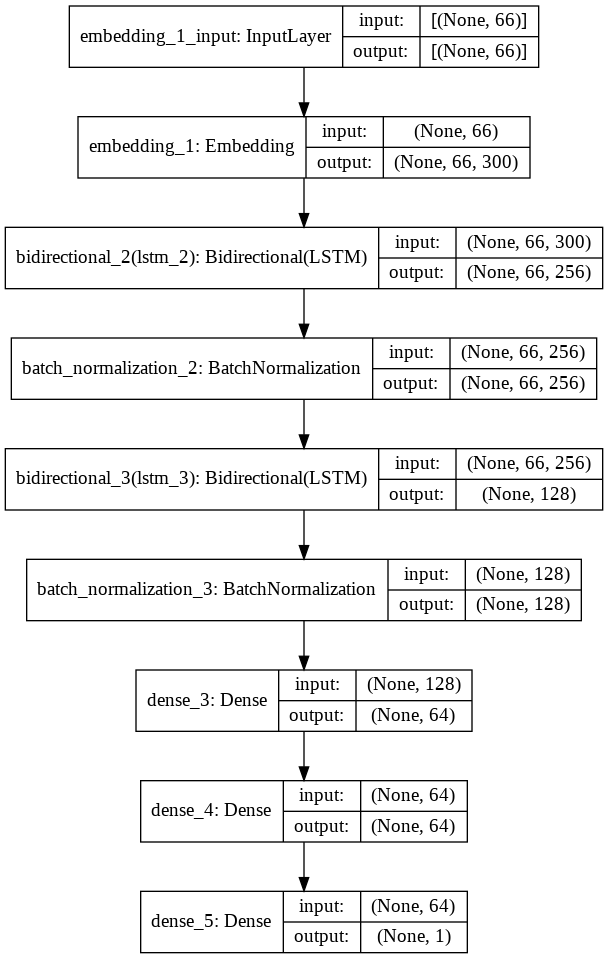

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
plot_model(model_glove, to_file='/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Model/Negative Detection/Learning Rate/0.01/model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model_glove.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 66, 300)           3923700   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 66, 256)           439296    
_________________________________________________________________
batch_normalization_2 (Batch (None, 66, 256)           1024      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)               

In [ ]:
history=model_glove.fit(x_train, y_train, epochs = 4, batch_size=64, validation_data=(x_test, y_test))

Epoch 1/4
170/170 [==============================] - 229s 1s/step - loss: 0.6097 - accuracy: 0.6576 - val_loss: 0.6479 - val_accuracy: 0.7322
Epoch 2/4
170/170 [==============================] - 185s 1s/step - loss: 0.3871 - accuracy: 0.8353 - val_loss: 0.4702 - val_accuracy: 0.8433
Epoch 3/4
170/170 [==============================] - 185s 1s/step - loss: 0.3285 - accuracy: 0.8554 - val_loss: 0.3221 - val_accuracy: 0.8756
Epoch 4/4
170/170 [==============================] - 185s 1s/step - loss: 0.2861 - accuracy: 0.8772 - val_loss: 0.2795 - val_accuracy: 0.8847


In [ ]:
y_pred = model_glove.predict(x_test)

In [ ]:
y_test

1979     1
9594     0
7064     0
10874    0
1229     1
        ..
9700     0
4079     1
9895     0
11442    0
12010    0
Name: sentiment, Length: 1206, dtype: int64

In [ ]:
y_pred

array([[0.9210626 ],
       [0.00253612],
       [0.01174557],
       ...,
       [0.00650755],
       [0.3298964 ],
       [0.10127124]], dtype=float32)

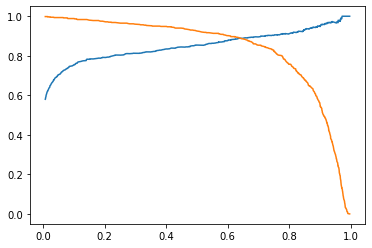

Crossover at 0.64 with recall 0.89
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       605
           1       0.89      0.89      0.89       601

    accuracy                           0.89      1206
   macro avg       0.89      0.89      0.89      1206
weighted avg       0.89      0.89      0.89      1206



In [ ]:
pr, rc, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(thresholds, pr[1:])
plt.plot(thresholds, rc[1:])
plt.show()
crossover_index = np.max(np.where(pr == rc))
crossover_cutoff = thresholds[crossover_index]
crossover_recall = rc[crossover_index]
print("Crossover at {0:.2f} with recall {1:.2f}".format(crossover_cutoff, crossover_recall))
print(classification_report(y_test, y_pred > crossover_cutoff))



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def ConfusionMatrix(y_pred, y_test):
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    group_counts = ["{0:0.0f}".format(value) for value in 
                    cf_matrix.flatten()]


    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

[[0.9210626 ]
 [0.00253612]
 [0.01174557]
 ...
 [0.00650755]
 [0.3298964 ]
 [0.10127124]]
1979     1
9594     0
7064     0
10874    0
1229     1
        ..
9700     0
4079     1
9895     0
11442    0
12010    0
Name: sentiment, Length: 1206, dtype: int64


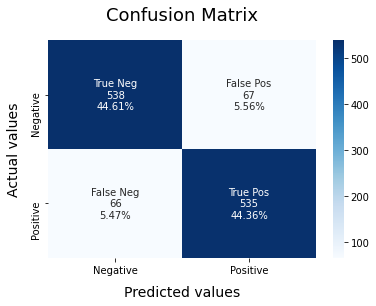

In [ ]:
# Predicting on the Test dataset.
y_pred = model_glove.predict(x_test)
print(y_pred)
print(y_test)
# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.64, 1, 0)

# Printing out the Evaluation metrics. 
ConfusionMatrix(y_pred, y_test)


In [ ]:
model_glove.save("/content/gdrive/MyDrive/Colab Notebooks/Tugas Akhir/Model/Negative Detection/Block LSTM/2 Block/Negative Detection 2 Block BiLSTM learning RMSProp 0.0001 Model.h5")